In [1]:
%matplotlib inline
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask
from astropy.table import Table, vstack
from astropy import units
import numpy as np
import matplotlib
import matplotlib.pylab as plt

visits = [181898, 182014, 193860, 194105, 197403, 199498, 212048]
filt = 'r'

#bigCat = Table.read('src_catalog_2.fits')

In [7]:
%matplotlib inline
import lsst.daf.persistence as dafPersist
import lsst.afw.table as afwTable
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage
from lsst.meas.algorithms import LoadIndexedReferenceObjectsTask
from astropy.table import Table, vstack
from astropy import units
import numpy as np
import matplotlib
import matplotlib.pylab as plt

visits = [181898, 182014, 193860, 194105, 197403, 199498, 212048]
filt = 'r'
butler = dafPersist.Butler("/sps/lsst/dataproducts/desc/DC2/Run1.2p/w_2018_18/data/output")

fluxType = "base_PsfFlux"
#fluxType = "base_CircularApertureFlux_6_0"

Flags = ["base_PixelFlags_flag_saturated", "base_PixelFlags_flag_cr", "base_PixelFlags_flag_interpolated",
         fluxType + "_flag", "base_SdssCentroid_flag", 
         "base_SdssCentroid_flag_almostNoSecondDerivative", "base_SdssCentroid_flag_edge", "base_SdssCentroid_flag_noSecondDerivative",
         "base_SdssCentroid_flag_notAtMaximum", "base_SdssCentroid_flag_resetToPeak", 
         "base_SdssShape_flag", "base_ClassificationExtendedness_flag"]

In [62]:
catList = []
for visit in visits:
    print('Reading visit:', visit)
    for count,data_ref in enumerate(butler.subset('src', visit=visit)):
        if data_ref.datasetExists():
            dataId = data_ref.dataId
        else:
            continue
        if count%10 == 0 :
            print(count, dataId)
        src = butler.get('src', dataId, immediate=True, flags=afwTable.SOURCE_IO_NO_FOOTPRINTS)
        v = src.asAstropy()

        # select sources
        cut = np.ones_like(v['id'], dtype=bool)
        for flag in Flags:
            cut &= v[flag]==False
        cut &= (v[fluxType + '_flux'] > 0) & (v[fluxType + '_flux'] / v[fluxType + '_fluxSigma'] > 5)
        cut &= v['base_ClassificationExtendedness_value'] < 0.5

        # get calibration object and then magnitudes with errors
        calib = butler.get("calexp_calib", dataId, immediate=True)
        mag, magErr = calib.getMagnitude(v[cut][fluxType + '_flux'], v[cut][fluxType + '_fluxSigma'])

        cat = v[cut]['id', 'coord_ra', 'coord_dec']
        cat['mag'] = mag
        cat['magErr'] = magErr

        # add dataId info
        for k in dataId.keys():
            if k == 'sensor' or k == 'raft':
                cat[k] = int(dataId[k][0])*10 + int(dataId[k][2])
            else:
                cat[k] = dataId[k]
            
        # hack to get rid of a warning related to a merging conflict
        cat.meta['NOISE_EXPOSURE_ID'] = 0
         
        # add catalog to the list    
        catList.append(cat)
        
# merge all individual catalogs into a single big one    
bigCat = vstack(catList)


Reading visit: 181898
0 {'visit': 181898, 'filter': 'r', 'raft': '2,0', 'sensor': '0,0'}
10 {'visit': 181898, 'filter': 'r', 'raft': '4,1', 'sensor': '0,0'}
20 {'visit': 181898, 'filter': 'r', 'raft': '3,2', 'sensor': '0,1'}
30 {'visit': 181898, 'filter': 'r', 'raft': '2,4', 'sensor': '0,2'}
40 {'visit': 181898, 'filter': 'r', 'raft': '1,4', 'sensor': '1,0'}
50 {'visit': 181898, 'filter': 'r', 'raft': '3,4', 'sensor': '1,0'}
60 {'visit': 181898, 'filter': 'r', 'raft': '2,4', 'sensor': '1,1'}
70 {'visit': 181898, 'filter': 'r', 'raft': '1,4', 'sensor': '1,2'}
80 {'visit': 181898, 'filter': 'r', 'raft': '3,4', 'sensor': '1,2'}
90 {'visit': 181898, 'filter': 'r', 'raft': '2,1', 'sensor': '2,0'}
100 {'visit': 181898, 'filter': 'r', 'raft': '4,2', 'sensor': '2,0'}
110 {'visit': 181898, 'filter': 'r', 'raft': '2,3', 'sensor': '2,1'}
120 {'visit': 181898, 'filter': 'r', 'raft': '1,0', 'sensor': '2,2'}
130 {'visit': 181898, 'filter': 'r', 'raft': '3,0', 'sensor': '2,2'}
Reading visit: 182014
0

In [ ]:
bigCat.write('src_catalog_2.fits')

In [63]:
bigCat

id,coord_ra,coord_dec,mag,magErr,visit,filter,raft,sensor
,rad,rad,,,,,,
int64,float64,float64,float64,float64,int64,str4,int64,int64
781246800068612,0.9228027357838563,-0.48038715752502675,16.03972970937184,0.0009238721720781951,181898,r,20,0
781246800068614,0.9227961395893789,-0.48075624165616515,23.68358788600547,0.13829896562135785,181898,r,20,0
781246800068618,0.9228419521503138,-0.4801536238152379,21.68426163715388,0.02424958709227266,181898,r,20,0
781246800068620,0.9227593326391457,-0.481802708256963,23.268921602548964,0.09680912741732613,181898,r,20,0
781246800068622,0.9228155152010822,-0.480676390988602,23.55990663368071,0.12372804842873387,181898,r,20,0
781246800068625,0.9227533544347606,-0.4821428547544376,22.209501195169796,0.03857283706682341,181898,r,20,0
781246800068626,0.9228112576538171,-0.4809557237483371,23.121449227612885,0.08403478387381941,181898,r,20,0
781246800068631,0.9228011621461983,-0.48151730457755504,23.37734301285829,0.1062602585047053,181898,r,20,0


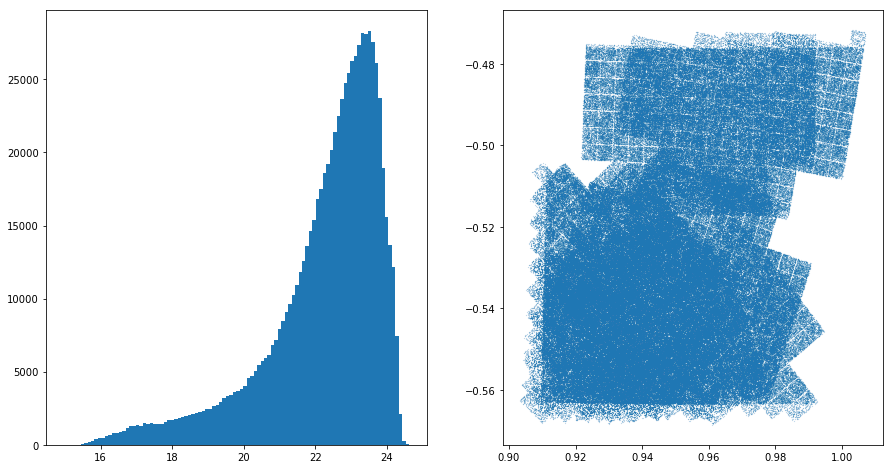

In [65]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 8))
_ = ax0.hist(bigCat['mag'], bins=100)
_ = ax1.scatter(bigCat['coord_ra'], bigCat['coord_dec'], s=0.01)

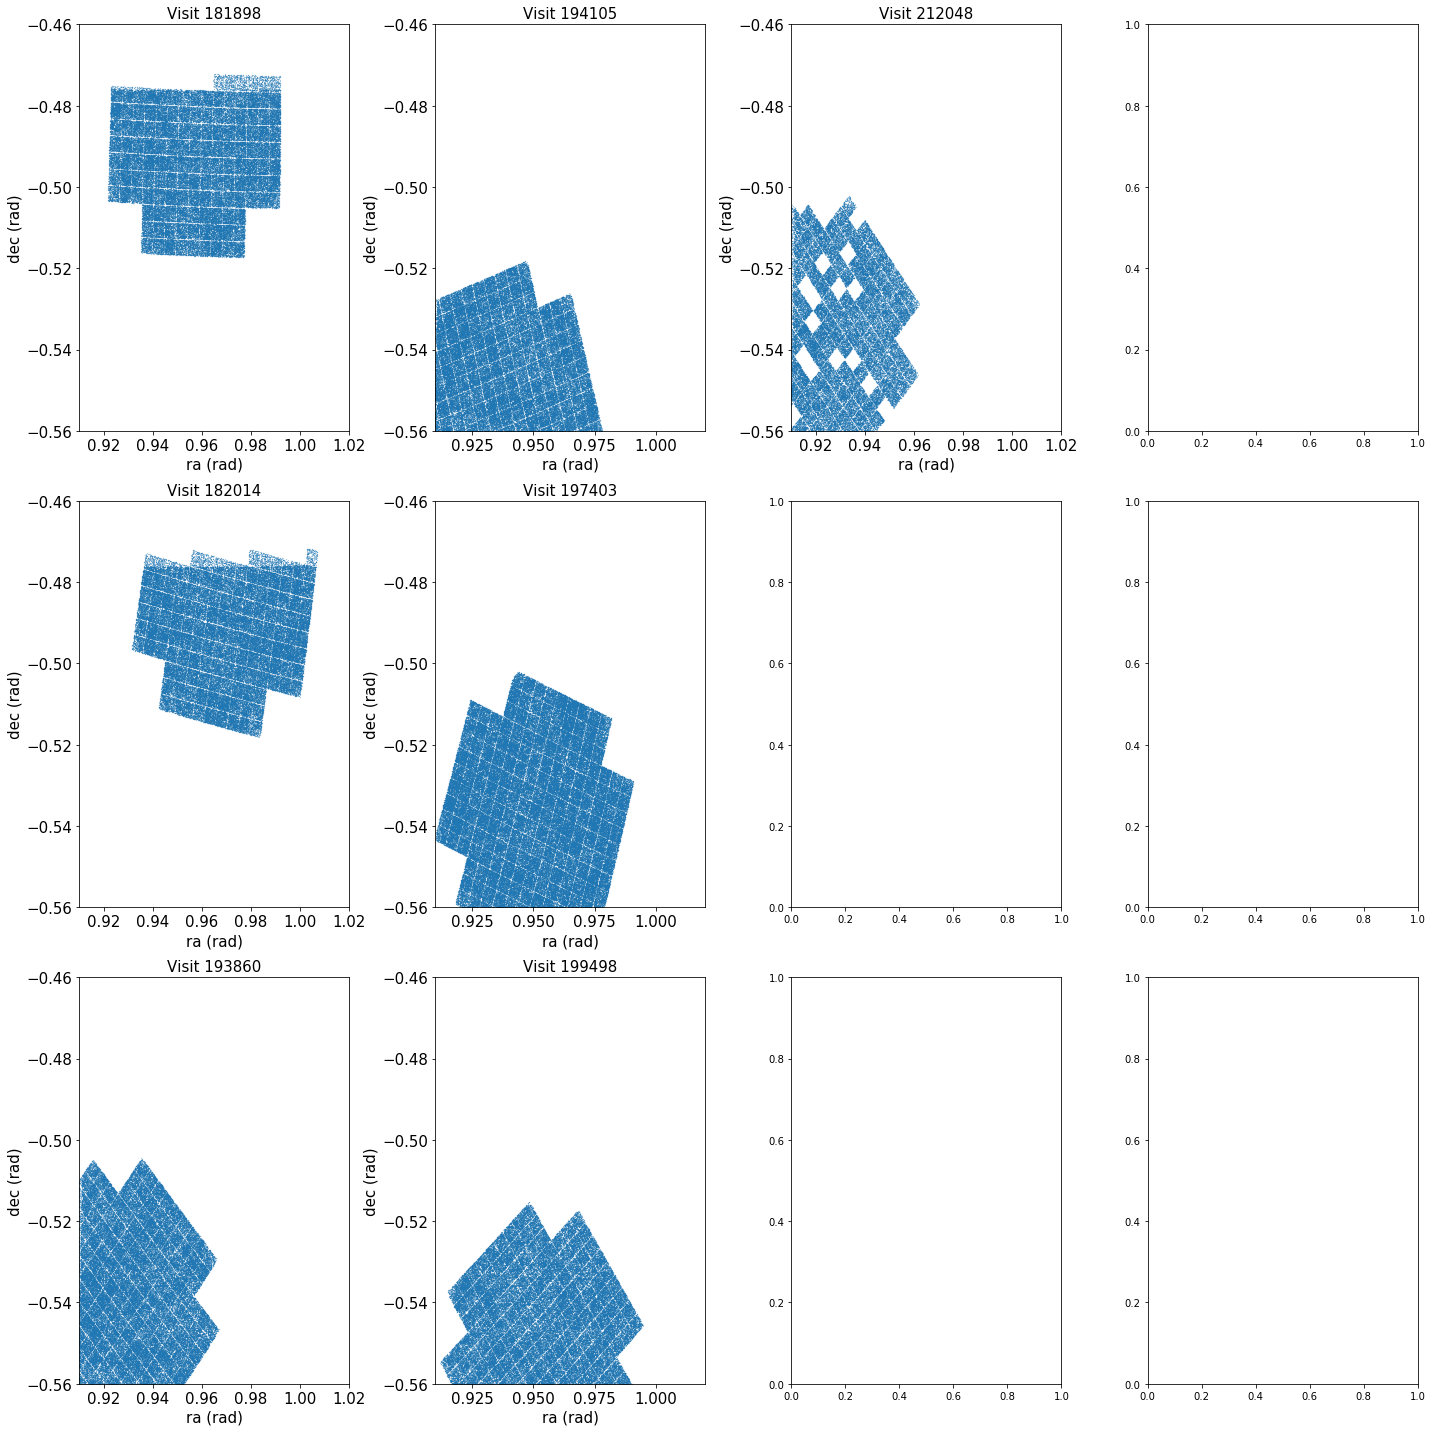

In [12]:
fig, ax = plt.subplots(ncols=4, nrows=3, figsize=(20,20))
for i,v in enumerate(visits):
    a = i%3
    b = i//3
    cut = bigCat['visit'] == v
    ax[a][b].scatter(bigCat[cut]['coord_ra'], bigCat[cut]['coord_dec'], s=0.02)
    ax[a][b].set_xlim([0.91,1.02])
    ax[a][b].set_ylim([-0.56, -0.46])
    ax[a][b].set_xlabel('ra (rad)', fontsize=15)
    ax[a][b].set_ylabel('dec (rad)', fontsize=15)
    ax[a][b].set_title('Visit %d'%(v), fontsize=15)
    ax[a][b].tick_params(labelsize=15)
    
fig.tight_layout()

In [42]:
#fig.savefig("ra_dec_r.png")

In [66]:
from astropy.coordinates import SkyCoord
from astropy import units as u

visits = [181898, 182014, 193860, 194105, 197403, 199498, 212048]
vRef = 197403

cRef = SkyCoord(ra = bigCat[bigCat['visit']==vRef]['coord_ra'], dec = bigCat[bigCat['visit']==vRef]['coord_dec'])

bigCat['dist'] = 999999.

dist = []
distNew = []
for count,v in enumerate(visits):
    if v == vRef:
        dist = dist + [9999.]*sum(bigCat['visit']==vRef)
        distNew = distNew + [9999.]*sum(bigCat['visit']==vRef)
        continue
    
    c = SkyCoord(ra = bigCat[bigCat['visit']==v]['coord_ra'], dec = bigCat[bigCat['visit']==v]['coord_dec'])
    idx, d2d, d3d = c.match_to_catalog_sky(cRef)
    dist = dist + d2d.milliarcsecond.tolist()
    
bigCat['dist'] = dist

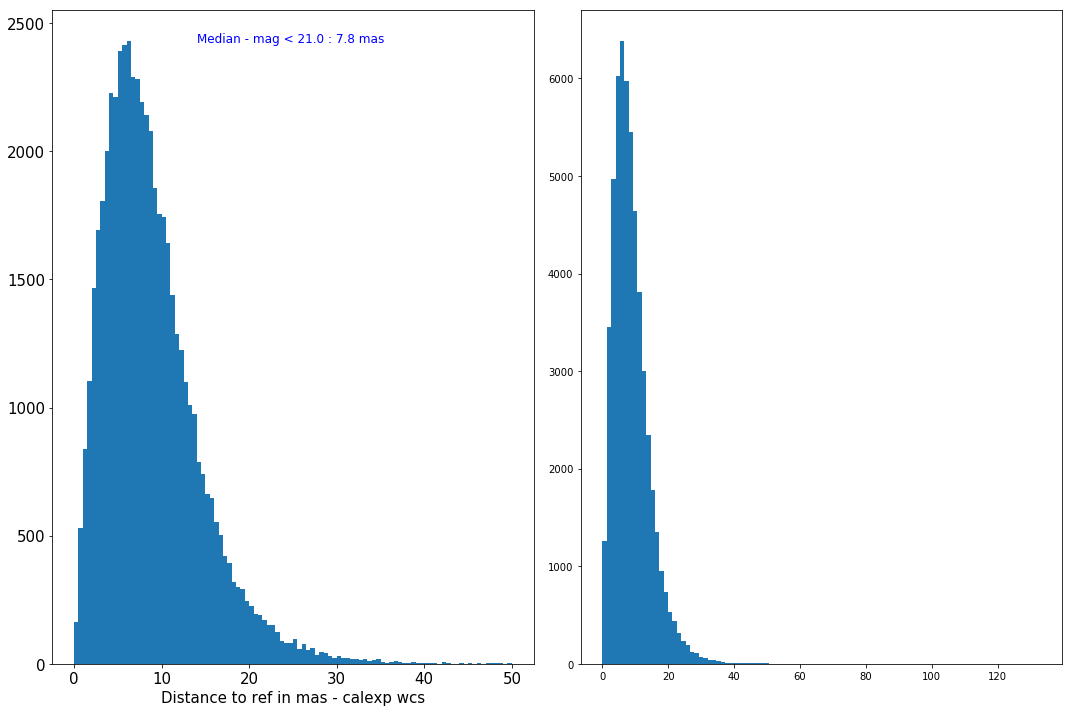

In [67]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 10))

magCut = 21
cut = (bigCat['dist'] < 300) & (bigCat['mag'] < magCut)
_ = ax0.hist(bigCat[cut]['dist'], bins=100, range = [0., 50])
_ = ax1.hist(bigCat[cut]['dist'], bins=100)

ax0.tick_params(labelsize=15)
ax0.set_xlabel('Distance to ref in mas - calexp wcs', fontsize=15)

ax0.annotate("Median - mag < %0.1f : %0.1f mas"%(magCut, np.median(bigCat[cut]['dist'])),
             fontsize=12, color='b', xy=(0.3, 0.95), xycoords='axes fraction')
                                                         
fig.tight_layout()

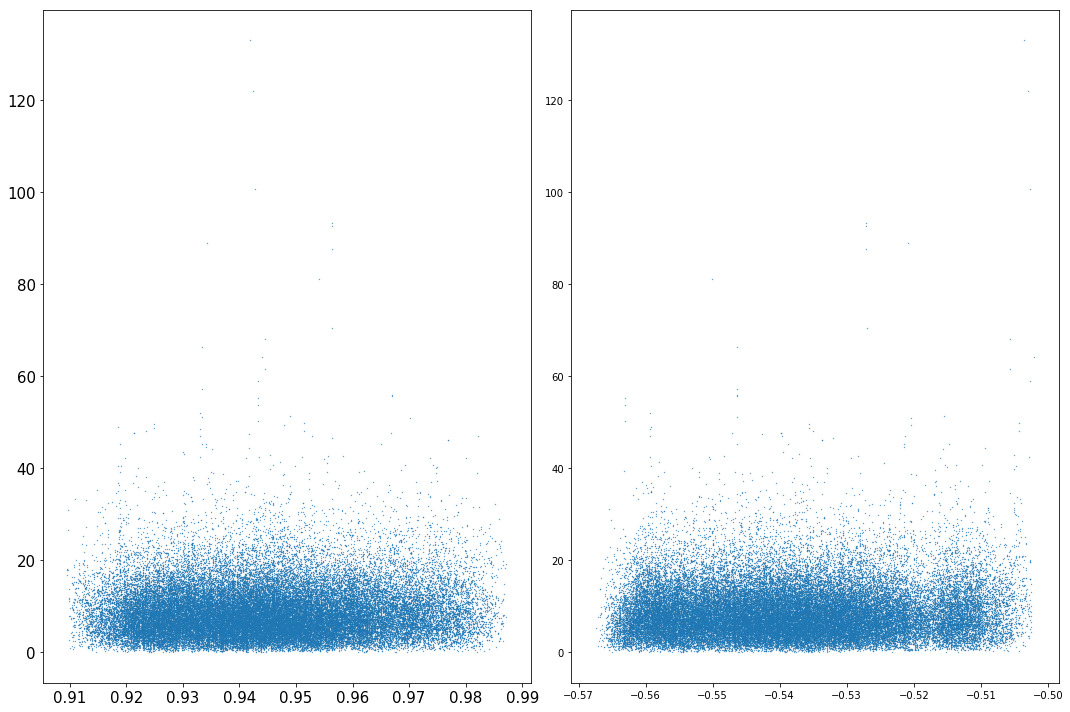

In [68]:
fig, (ax0, ax1) = plt.subplots(ncols=2, figsize=(15, 10))

magCut = 21
cut = (bigCat['dist'] < 300) & (bigCat['mag'] < magCut)
_ = ax0.scatter(bigCat[cut]['coord_ra'],bigCat[cut]['dist'], s=0.1)
_ = ax1.scatter(bigCat[cut]['coord_dec'],bigCat[cut]['dist'], s=0.1)

ax0.tick_params(labelsize=15)
#ax0.set_xlabel('Distance to ref in mas - calexp wcs', fontsize=15)

#ax0.annotate("Median - mag < %0.1f : %0.1f mas"%(magCut, np.median(bigCat[cut]['dist'])),
#             fontsize=12, color='b', xy=(0.3, 0.95), xycoords='axes fraction')
                                                         
fig.tight_layout()

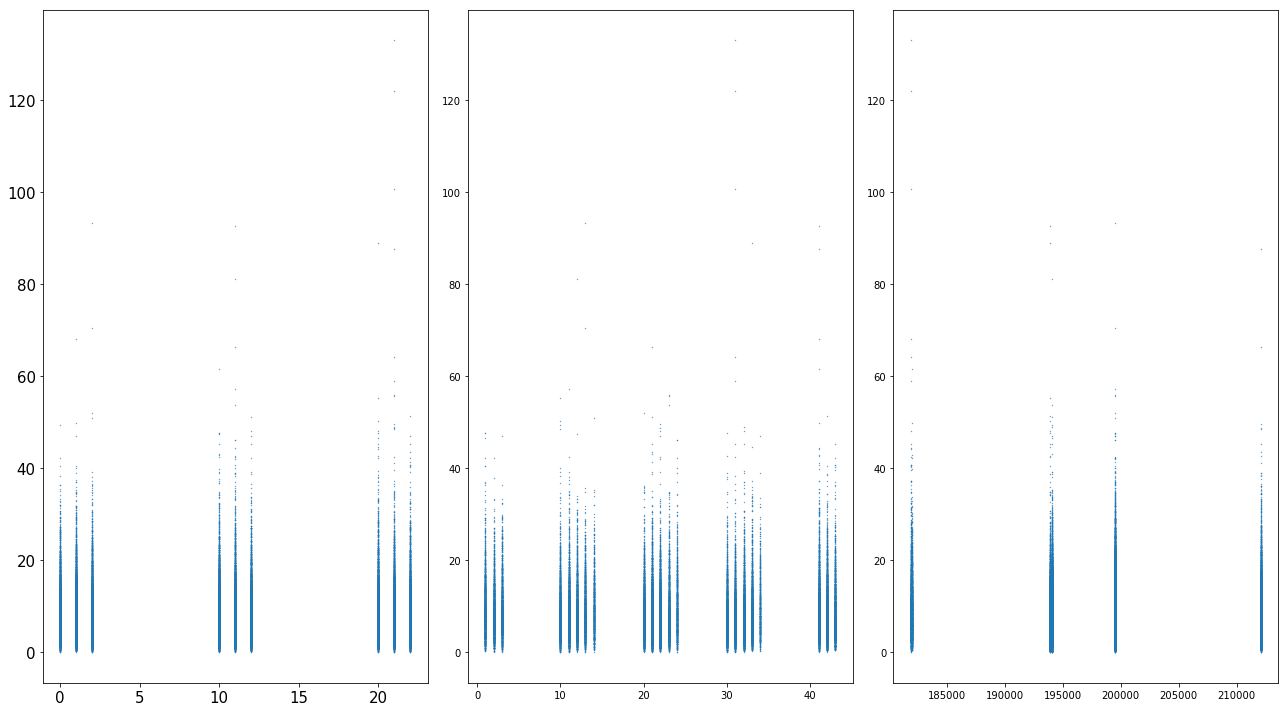

In [71]:
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(18, 10))

magCut = 21
cut = (bigCat['dist'] < 300) & (bigCat['mag'] < magCut)
_ = ax0.scatter(bigCat[cut]['sensor'],bigCat[cut]['dist'], s=0.1)
_ = ax1.scatter(bigCat[cut]['raft'],bigCat[cut]['dist'], s=0.1)
_ = ax2.scatter(bigCat[cut]['visit'],bigCat[cut]['dist'], s=0.1)

ax0.tick_params(labelsize=15)
#ax0.set_xlabel('Distance to ref in mas - calexp wcs', fontsize=15)

#ax0.annotate("Median - mag < %0.1f : %0.1f mas"%(magCut, np.median(bigCat[cut]['dist'])),
#             fontsize=12, color='b', xy=(0.3, 0.95), xycoords='axes fraction')
                                                         
fig.tight_layout()

In [43]:
a = [bigCat[cut]['sensor'][i] for i in range(len(bigCat[cut]))]

KeyboardInterrupt: 

In [61]:
int(dataId[k][0])*10 + int(dataId[k][2])

22

In [49]:
dataId.keys()

dict_keys(['visit', 'filter', 'raft', 'sensor'])

In [118]:
fig.savefig("DC2_astrometry.png")